## MLP 

We have considered adequated to treat this problem as natural language processing is normally treated. We have sequences of words that behave according to hidden grammar rules that the MLP has to learn in order the predict what word comes next. (Analogous to having a sequence of products that behave according to hidden market rules we need to learn in order to predict what product comes next).

Our training set can be made up of ALL the users, but we will 'hide' the last product they have purchased. That is 

- X_train = Sequence of products all users bought but the last one. 80%
- y_train = target we need to predict, that will be the last product they've purchased. 80%

- X_test = Sequence of all products but the last one 20%
- y_test = Last product this 20% have bought.

**Remarks:**

- We can add these 20% to the X_train (we shall give the sequence of the purchased products but the last two.) and add the 'penultimo' to the y_train.

- We can multiply the training set by transforming the sequence of products 'abcde' to 'ab' 'abc' 'abcd' 'abcde'. (Is it a good idea? It seems ok to me, why ? Test what is better.

- We can add the test.txt to the training set without no problem. (Yes, no?)

- We MUST delete users with only one product, they have no training value. We can use to test but eh. I would just delete them.

- Do some kind of selection of the 'best' users to train the net?

- We are not using the Socio_Demo features, it would be nice to treat them with another approach and then combine the two.




In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot


In [3]:
#Load the data
dftrain = pd.read_csv('train2-2.txt', sep='|')
dftest = pd.read_csv('test2.txt', sep= '|')

In [4]:
dftrain.head(7)

,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05
0,A0000001,601,2007-05,5,4,3,1,0
1,A0000001,704,2013-04,5,4,3,1,0
2,A0000001,2501,2006-03,5,4,3,1,0
3,A0000001,2503,2006-03,5,4,3,1,0
4,A0000001,1011,2011-04,5,4,3,1,0
5,A0000002,601,1998-06,5,5,1,1,0
6,A0000002,801,2006-02,5,5,1,1,0


In [5]:
dftrain.drop('Socio_Demo_04', axis= 1, inplace=True)

As argued we directly delete the feature gender for etical reasons.

In [6]:
dftrain['Prod_int'] = np.zeros(dftrain.ID_Customer.size, dtype=int)
dftrain.head(6)

,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_05,Prod_int
0,A0000001,601,2007-05,5,4,3,0,0
1,A0000001,704,2013-04,5,4,3,0,0
2,A0000001,2501,2006-03,5,4,3,0,0
3,A0000001,2503,2006-03,5,4,3,0,0
4,A0000001,1011,2011-04,5,4,3,0,0
5,A0000002,601,1998-06,5,5,1,0,0


We  filter the data, deleting products that have low sells. We have tried three cases, 100, 300 and 2500

In [7]:
Sells_per_product = dftrain.groupby('Cod_Prod').ID_Customer.count()
Sells_per_product.describe()

count        94.000000
mean      35644.691489
std       96394.340067
min           1.000000
25%         364.250000
50%        3205.500000
75%       15433.500000
max      661756.000000
Name: ID_Customer, dtype: float64

As we have previously commented when exploring the data there is a vast ammount of products with close to no sells compared to the 'best sellers', that is clearly reflected on the high variance.

In [8]:
#Explore the effect that will have deleting low selling products.

products_sub100 = Sells_per_product[Sells_per_product <100].index.values
products_sub300 = Sells_per_product[Sells_per_product < 300].index.values
products_sub2500 = Sells_per_product[Sells_per_product <2500].index.values
print products_sub100.shape, products_sub300.shape , products_sub2500.shape
a = Sells_per_product[Sells_per_product <100].sum()/float(Sells_per_product.sum())*100
b = Sells_per_product[Sells_per_product <300].sum()/float(Sells_per_product.sum())*100
c = Sells_per_product[Sells_per_product <2500].sum()/float(Sells_per_product.sum())*100
print 'Percentage of sells that we are droping: {0:.5f}%, {1:.5f}%, {2:.5f}%'.format(a, b, c)
products_sub300

(16,) (23,) (43,)
Percentage of sells that we are droping: 0.01128%, 0.05492%, 0.78246%


array([ 101,  104,  502,  504,  703,  803,  804, 1004, 1005, 1006, 1008,
       1010, 1014, 1015, 1305, 1308, 1312, 1803, 1806, 2104, 2502, 2801,
       2901])

In any case we are dropping less than 1% of the sells, so we expect our accuracy to not be affected by more than 1% by this simplifications. Given the vast ammount of data and supposing the test and the train where created under the same conditions this is a safe assumption to make.

In [9]:
#Filter the data in three groups.
#We delete rare products
df100 = dftrain.query('Cod_Prod not in @products_sub100')
df300 = dftrain.query('Cod_Prod not in @products_sub300')
df2500 = dftrain.query('Cod_Prod not in @products_sub2500')

We have done diferent tests and achived the best results dropping all the products sub2500. From now on we shall only work with these data.

Now we have to prepare the data we will feed to the MLP.

### Clean the data set and drop users that only bought one product

In [10]:
#Clean the datafram of useless users. 
#Users that have only bought one product and thus will be useless for the MLP

def users_one_buy_clean(df):
    """
    Cleans the data frame from users that have only bought one product.
    Returns dataframe
    """
    dropusers = df.groupby('ID_Customer')['Cod_Prod'].count()
    dropusers = dropusers[dropusers == 1]
    users_to_drop= dropusers.index
    filtered_df = df.query('ID_Customer not in @users_to_drop')
    return filtered_df

In [11]:
df2500 = users_one_buy_clean(df2500)

As we have argued clients with diferent Socio_Demo_5 will probably be interested in diferent products. So training a diferent MLP for each S5 seems like a good bet.

In [12]:
#Divide the data between different S5 values
#We split the data set into subcategories acording to its S5

df2500_0 = df2500.query('Socio_Demo_05 == 0')
df2500_1 = df2500.query('Socio_Demo_05 == 1')
df2500_2 = df2500.query('Socio_Demo_05 == 2')
df2500_3 = df2500.query('Socio_Demo_05 == 3')

In [13]:
df2500_0.head(10)

,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_05,Prod_int
0,A0000001,601,2007-05,5,4,3,0,0
1,A0000001,704,2013-04,5,4,3,0,0
2,A0000001,2501,2006-03,5,4,3,0,0
3,A0000001,2503,2006-03,5,4,3,0,0
4,A0000001,1011,2011-04,5,4,3,0,0
5,A0000002,601,1998-06,5,5,1,0,0
6,A0000002,801,2006-02,5,5,1,0,0
7,A0000002,9992,2015-02,5,5,1,0,0
8,A0000002,301,1995-03,5,5,1,0,0
9,A0000003,601,1985-11,5,5,5,0,0


### Create a ghost product.

This ghost product will tell our model the '1990-01' mark, the year after most products started to be aviable.


In [14]:
fecha = '1990-01'

In [15]:
#Creation of the ghost product

def ghost_product(data, fecha):
    
    '''
    Adds a the ghost product to every user. Returns a data frame 
    '''

    customers = data.ID_Customer.unique()

    #Create a df with the ghost product following the required shape
    
    df_fecha_total_prod = pd.DataFrame(np.zeros((customers.size, data.columns.size), dtype = int), columns= data.columns)
    df_fecha_total_prod['Cod_Fecha']= fecha
    df_fecha_total_prod.Cod_Prod = 1
    df_fecha_total_prod.ID_Customer = customers
    #Concatenate with the original dataframe and order by customer
    df_fecha_total_prod.index = range(data.index.size , data.index.size + customers.size, 1)
    new_df = pd.concat([df_fecha_total_prod, data])
    new_df.sort_values('ID_Customer', inplace = True)
    return new_df

In [16]:
df2500_0 = ghost_product(df2500_0, fecha)
df2500_1 = ghost_product(df2500_1, fecha)
df2500_2 = ghost_product(df2500_2, fecha)
df2500_3 = ghost_product(df2500_3, fecha)

*** NOW WE HAVE TO SET THE INT ***

In [17]:
def prod_int_fill(df):
    """
    takes dataframe and returns with the cloumns Prod_int filled
    """
#Fill the column of Prod_int, this will be the labels the mlp will work with
#We will save the identificator '0' to indicate 'no purchase'. This will become clear when designing the MLP

    products=df.Cod_Prod.unique()
    products=np.sort(products)
    for i in range(products.size):
        df.loc[df['Cod_Prod'] == products[i], 'Prod_int'] = i+1
    return df

In [18]:
df2500_0 = prod_int_fill(df2500_0)
df2500_0.head()

,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_05,Prod_int
2569763,A0000001,1,1990-01,0,0,0,0,1
2,A0000001,2501,2006-03,5,4,3,0,38
3,A0000001,2503,2006-03,5,4,3,0,39
4,A0000001,1011,2011-04,5,4,3,0,16
1,A0000001,704,2013-04,5,4,3,0,8


### We have treated the data: deleted low selling products, deleted users with only one buy, split taking into account S5 and added  variable.

In [72]:
#Lets run a couple of tests to see everything is OK.
buys_per_customer = df2500_0.groupby('ID_Customer')['Cod_Prod'].count()
buys_per_customer[buys_per_customer <=2]

Series([], Name: Cod_Prod, dtype: int64)

In [75]:
#Should be equal. We started setting ints at 1! Not 0!
print df2500_0.Cod_Prod.unique().size
print np.max(df2500_0.Prod_int.values)

52
52


In [77]:
#Divide the clients in training and test

def train_test(df, test_size=0.2):
    """
    Divides the data randomly into train and test by users returns (df_train , df_test)
    df: data to split
    test_size: size in % of the test. default 0.2.
    """
    Validusers= df['ID_Customer'].unique()
    users_for_test = np.random.choice(Validusers, size= int(len(Validusers)*test_size), replace= False)
    data_test = df.query('ID_Customer in @users_for_test')
    data_train = df.query('ID_Customer not in @users_for_test')
    print 'Users for test: ', data_test.shape
    print 'Users for train: ', data_train.shape
    return data_train, data_test

In [78]:
## Split into test train

train_0_2500, test_0_2500 = train_test(df2500_0)
#train_1_2500, test_1_2500 = train_test(df2500_1)
#train_2_2500, test_2_2500 = train_test(df2500_2)
#train_3_2500, test_3_2500 = train_test(df2500_3)

Users for test:  (614112, 8)
Users for train:  (2460042, 8)


In [79]:
train_0_2500.head()

,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_05,Prod_int
2569763,A0000001,1,1990-01,0,0,0,0,1
2,A0000001,2501,2006-03,5,4,3,0,38
3,A0000001,2503,2006-03,5,4,3,0,39
4,A0000001,1011,2011-04,5,4,3,0,16
1,A0000001,704,2013-04,5,4,3,0,8


## A partir de aqui solo has continuado con train_0_2500 y test

In [80]:
#Get the purhcase history of every customer
historial_users_train_0_2500=train_0_2500.groupby(['ID_Customer', 'Prod_int'])['Cod_Fecha'].first()
historial_users_test_0_2500=test_0_2500.groupby(['ID_Customer', 'Prod_int'])['Cod_Fecha'].first()
historial_users_train_0_2500.head(6)

ID_Customer  Prod_int
A0000001     1           1990-01
             6           2007-05
             8           2013-04
             16          2011-04
             38          2006-03
             39          2006-03
Name: Cod_Fecha, dtype: object

In [84]:
#Sort by fecha and convert indices to a sequences of list

historial_users_train_0_2500.sort_values(inplace = True)
historial_users_test_0_2500.sort_values(inplace = True)

In [106]:
#We extract the list of products with the most recent one in the last position. We convert them to lists.
X_train = historial_users_train_0_2500.reset_index().groupby('ID_Customer')['Prod_int'].apply(np.array).values.tolist()
X_test = historial_users_test_0_2500.reset_index().groupby('ID_Customer')['Prod_int'].apply(np.array).values.tolist()

In [86]:
X_train[:7]

[array([ 1, 39, 38,  6, 16,  8]),
 array([ 1,  4,  6, 12, 51]),
 array([ 6,  1, 39, 38,  4,  3]),
 array([ 1,  6,  4,  3, 35]),
 array([4, 6, 1]),
 array([ 1,  4, 52, 50, 33,  6, 36]),
 array([ 1, 36, 52, 50,  6,  4, 16, 33,  8])]

Now we have to delete the last products in order to produce the output and the input!

In [115]:
#Dividimos entre X_train i y_train # SOLO EJECUTAR UNA VEZ BORRA COSAS
#Copy the last product to the target and then delete

X_traindel= np.copy(X_train)
X_testdel = np.copy(X_test)
y_train=np.zeros(len(X_train), dtype=int)
y_test=np.zeros(len(X_test), dtype=int)

i=0
for hist in X_train:
    if hist[-1:] != 1:
        y_train[i]=hist[-1:]
        X_traindel[i]= np.delete(X_traindel[i], X_traindel[i].size-1)
    else:
    #If the last product is the ghost product 1990 then we assign the preceding and delete two
        y_train[i]=hist[-2:-1]
        X_traindel[i]= np.delete(X_traindel[i], X_traindel[i].size-1)
        X_traindel[i]= np.delete(X_traindel[i], X_traindel[i].size-1) #Delete two times the last one ! So the last two
    i=i+1
i=0
for hist in X_test:
    if hist[-1:] != 1: #Prod_int ghost = 1
        y_test[i]=hist[-1:]
        X_testdel[i]= np.delete(X_test[i], X_test[i].size-1)
    else:
    #If the last product is the ghost product 1990 then we assign the preceding and delete two
        y_test[i]=hist[-2:-1]
        X_testdel[i]= np.delete(X_testdel[i], X_testdel[i].size-1)
        X_testdel[i]= np.delete(X_testdel[i], X_testdel[i].size-1)
    i=i+1

In [116]:
X_train[:7]

[array([ 1, 39, 38,  6, 16,  8]),
 array([ 1,  4,  6, 12, 51]),
 array([ 6,  1, 39, 38,  4,  3]),
 array([ 1,  6,  4,  3, 35]),
 array([4, 6, 1]),
 array([ 1,  4, 52, 50, 33,  6, 36]),
 array([ 1, 36, 52, 50,  6,  4, 16, 33,  8])]

In [117]:
print X_traindel[:5]
print y_train[:5]

[array([ 1, 39, 38,  6, 16]) array([ 1,  4,  6, 12])
 array([ 6,  1, 39, 38,  4]) array([1, 6, 4, 3]) array([4])]
[ 8 51  3 35  6]


Everything is ok!

In [118]:
Validusers= df2500_0.ID_Customer.unique()
for i in np.random.choice(np.arange(len(X_train)), size=3):
    print 'Historial Usuario (en Train): ', i
    print X_train[i]
    print y_train[i]
    print X_traindel[i]
for i in np.random.choice(np.arange(len(X_test)), size=3):
    print 'Historial Usuario (en test): ', i
    print X_train[i]
    print y_train[i]
    print X_traindel[i]

  

Historial Usuario (en Train):  75744
[ 1  4 52 50  6]
6
[ 1  4 52 50]
Historial Usuario (en Train):  29456
[4 6 1]
6
[4]
Historial Usuario (en Train):  120955
[ 1  6  4 33 52 50]
50
[ 1  6  4 33 52]
Historial Usuario (en test):  33352
[ 1  4 12 49  6  3]
3
[ 1  4 12 49  6]
Historial Usuario (en test):  39070
[ 1  4 44  3 40 36 41 50 52 16  6 33]
33
[ 1  4 44  3 40 36 41 50 52 16  6]
Historial Usuario (en test):  29707
[ 1 33  6 40 44  4 36 47 14 41 45  3]
3
[ 1 33  6 40 44  4 36 47 14 41 45]


We are double sure that everything is ok. We have created the appropiate target and input.

We shall now create the MLP model and fit it.

First we shall explore our training set. 

In [119]:
#Hacemos copia porque habra que jugar un poco
X_train=np.copy(X_traindel)
X_test=np.copy(X_testdel)
print 'Number of product sequences: ', len(X_train)
print 'Number of last objects:', y_train.size

Number of product sequences:  403513
Number of last objects: 403513


Mean lenght:  5.09029696689 Std:  2.73919931406


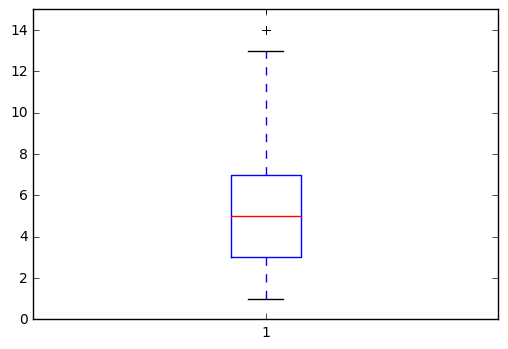

In [120]:
#Sumarize sequence lenght
size= map(len, X_train) #Applies function (len) to the sublists of X
print 'Mean lenght: ', np.mean(size), 'Std: ', np.std(size)
pyplot.boxplot(size)
pyplot.ylim(ymax=15)
pyplot.show()

The mean is 5.096 products with a std of 2.73 products, the median is 5 products. It is clear that we can get the full purchase historic for most users for sequences with a fixed lenght of 6. (From 1-7)

Let's start building our model:

In [121]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
#Fix randome seed
seed=7
np.random.seed(seed)

Using TensorFlow backend.


In [122]:
#Truncate or pad the sequences into maximum fixe lenght of 6
max_products=6
X_train = sequence.pad_sequences(X_train, maxlen=max_products)
X_test = sequence.pad_sequences(X_test, maxlen= max_products)

In [124]:
X_train[:7]

array([[ 0,  1, 39, 38,  6, 16],
       [ 0,  0,  1,  4,  6, 12],
       [ 0,  6,  1, 39, 38,  4],
       [ 0,  0,  1,  6,  4,  3],
       [ 0,  0,  0,  0,  0,  4],
       [ 1,  4, 52, 50, 33,  6],
       [52, 50,  6,  4, 16, 33]], dtype=int32)

In [123]:
print X_train.shape
print X_test.shape
print X_train[0]

(403513, 6)
(100878, 6)
[ 0  1 39 38  6 16]


In [151]:
#Output classes, should be one less than original products. (ghost product)
print 'Classes: '
print np.unique(y_test).shape
print np.unique(y_train).shape
nclasses = np.unique(y_test).shape[0]
print nclasses

Classes: 
(51,)
(51,)
51


In [163]:
top_product=np.max(X_train)+1
print 'Vocabulary Size: ', top_product
print np.max(df2500_0.Prod_int) #OK

Vocabulary Size:  53
52


In [164]:
#Create the model:
def base_model(top_product, vsdim , max_products, nclasses):
    """
    Creamos un modelo, 
    max_products: input_lenght.
    vsdim: defautl = 10 dimension del epsacio vectorial donde hcemos word embedding
    top_product: Vocabulary size. Max label de los productos
    """
    model = Sequential()
    model.add(Embedding(top_product , vsdim, input_length=max_products))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dense(100, activation ='relu'))
    model.add(Dense(nclasses+2, activation='sigmoid')) ## 0 and 1 where occupied by ghost. No time to fix this 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [176]:
vsdim = 5 #Fijamos la dimension del espacio vectorial.
model_0 = base_model(top_product, vsdim, max_products, nclasses)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_5 (Embedding)          (None, 6, 5)          265         embedding_input_5[0][0]          
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 30)            0           embedding_5[0][0]                
____________________________________________________________________________________________________
dense_17 (Dense)                 (None, 200)           6200        flatten_5[0][0]                  
____________________________________________________________________________________________________
dense_18 (Dense)                 (None, 200)           40200       dense_17[0][0]                   
___________________________________________________________________________________________

In [166]:
#Transformamos 
from keras.utils.np_utils import to_categorical

y_cat_train = to_categorical(y_train, nb_classes=None)
y_cat_test = to_categorical(y_test, nb_classes=None)

In [167]:
print y_train[:3]
print np.max(y_train)
print np.min(y_train)

[ 8 51  3]
52
2


The first two are the ghosts products, 'did not buy anything' and '1900 mark'

In [168]:
print y_cat_train[:3]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [169]:
print y_cat_train.shape
print X_train.shape
X_train[:3]

(403513, 53)
(403513, 6)


array([[ 0,  1, 39, 38,  6, 16],
       [ 0,  0,  1,  4,  6, 12],
       [ 0,  6,  1, 39, 38,  4]], dtype=int32)

In [170]:
y_train[:3]

array([ 8, 51,  3])

In [177]:
#Fit the model

model_0.fit(X_train, y_cat_train, validation_data=(X_test, y_cat_test), nb_epoch=3, batch_size=128, verbose=1)

scores=model_0.evaluate(X_test, y_cat_test, verbose=0)

print 'Accuracy: ', (scores[1]*100), '%'

Train on 403513 samples, validate on 100878 samples
Epoch 1/3
403513/403513 [==============================] - 20s - loss: 2.0779 - acc: 0.3796 - val_loss: 1.8374 - val_acc: 0.4868
Epoch 2/3
403513/403513 [==============================] - 20s - loss: 1.8210 - acc: 0.4894 - val_loss: 1.8023 - val_acc: 0.4938
Epoch 3/3
403513/403513 [==============================] - 20s - loss: 1.7925 - acc: 0.4953 - val_loss: 1.7904 - val_acc: 0.4957
Accuracy:  49.5737425406 %
